# 🔍 ANÁLISE EXPLORATÓRIA DE DADOS (EDA)

**Objetivo:** Entender os dados e identificar padrões que influenciam a **inadimplência** de clientes.

## 📌 O que vamos descobrir:
- Qualidade dos dados (missing, duplicatas)
- Quem são os inadimplentes?
- Quais variáveis mais impactam o risco de crédito?
- Dados estão prontos para Machine Learning?

In [2]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as stats
import warnings
warnings.filterwarnings('ignore')

# Configs de visualização
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("Set2")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10
%matplotlib inline

pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

print("✅ Bibliotecas carregadas!")

✅ Bibliotecas carregadas!


In [3]:
# Carregando dados do SQLite
DB_PATH = 'data/database.db'

conn = sqlite3.connect(DB_PATH)
df = pd.read_sql("SELECT * FROM clientes", conn)
conn.close()

print(f"📊 Dados carregados: {df.shape[0]:,} clientes × {df.shape[1]} variáveis")
print(f"🎯 Target: inadimplente (0=Adimplente, 1=Inadimplente)")

📊 Dados carregados: 100,000 clientes × 17 variáveis
🎯 Target: inadimplente (0=Adimplente, 1=Inadimplente)


---
# 1️⃣ VISÃO GERAL DOS DADOS
---

In [53]:
print("📋 Amostra dos dados:\n")
display(df.head())

print("📊 Estrutura do dataset:\n")
df.info()

print("🔍 VERIFICAÇÃO DE QUALIDADE")
print("=" * 60)

# Valores nulos
print(f"\n❓ Valores nulos: {df.isnull().sum().sum()}")

# Duplicatas
duplicatas = df.duplicated().sum()
print(f"🔄 Duplicatas: {duplicatas}")

📋 Amostra dos dados:



,id_cliente,idade,genero,estado_civil,escolaridade,estado,renda_anual,valor_patrimonio,possui_imovel_proprio,possui_carro,ocupacao,numero_dependentes,tempo_emprego_atual,score_serasa_externo,utilizacao_limite_cartao,historico_atraso_90_dias,inadimplente
0,1,47,M,Divorciado,Médio,RJ,9059.86,50709.30,1,0,CLT,2,316,698,11.50,0,0
1,2,37,F,Casado,Médio,PR,40713.82,140855.24,1,1,CLT,1,356,389,65.60,2,1
2,3,49,M,Casado,Médio,BA,72448.95,318428.40,1,1,CLT,3,358,428,0.00,0,0
3,4,62,F,Casado,Médio,SP,42668.42,98233.00,1,1,CLT,3,34,560,77.55,1,0
4,5,36,M,Casado,Superior,RS,46197.81,187751.14,0,1,Autônomo,1,290,475,41.52,0,0


📊 Estrutura do dataset:

<class 'pandas.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 17 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   id_cliente                100000 non-null  int64  
 1   idade                     100000 non-null  int64  
 2   genero                    100000 non-null  str    
 3   estado_civil              100000 non-null  str    
 4   escolaridade              100000 non-null  str    
 5   estado                    100000 non-null  str    
 6   renda_anual               100000 non-null  float64
 7   valor_patrimonio          100000 non-null  float64
 8   possui_imovel_proprio     100000 non-null  int64  
 9   possui_carro              100000 non-null  int64  
 10  ocupacao                  100000 non-null  str    
 11  numero_dependentes        100000 non-null  int64  
 12  tempo_emprego_atual       100000 non-null  int64  
 13  score_serasa_externo      10000

### ✋ OBSERVAÇÃO
**100.000 clientes** no Dataset, zero valores nulos e zero duplicatas. Dados prontos para modelagem sem necessidade de limpeza inicial.


---
# 2️⃣ ANÁLISE DO TARGET (INADIMPLÊNCIA)
---

🎯 DISTRIBUIÇÃO DO TARGET

✅ Adimplentes (0): 80,797 (80.8%)
❌ Inadimplentes (1): 19,203 (19.2%)


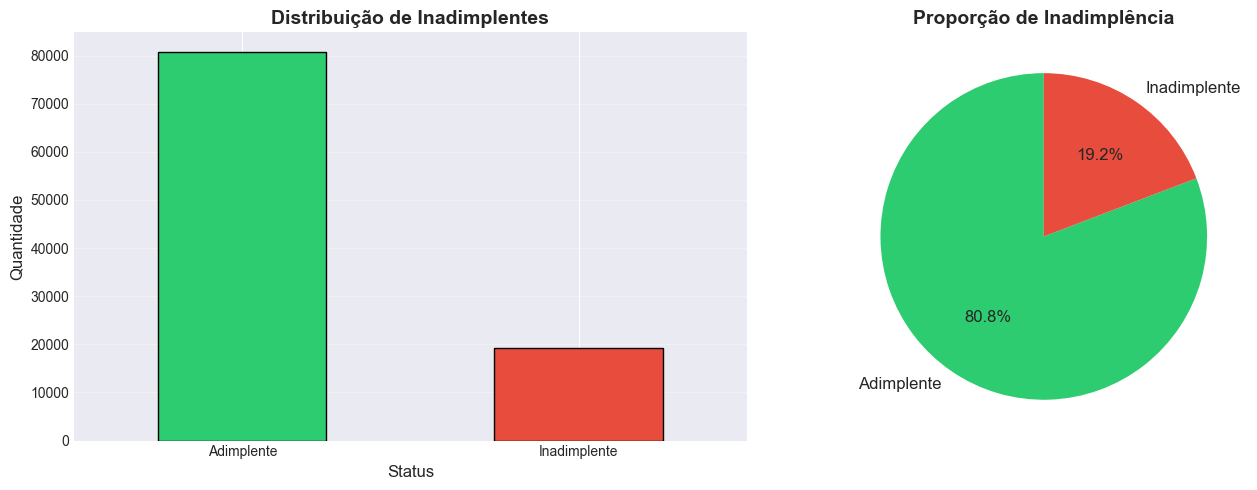

In [ ]:
# Distribuição da Inadimplência
inadimplencia = df['inadimplente'].value_counts()
percentuais = df['inadimplente'].value_counts(normalize=True) * 100

print("🎯 DISTRIBUIÇÃO DO TARGET")
print("=" * 60)
print(f"\n✅ Adimplentes (0): {inadimplencia[0]:,} ({percentuais[0]:.1f}%)")
print(f"❌ Inadimplentes (1): {inadimplencia[1]:,} ({percentuais[1]:.1f}%)")

# Gráficos
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

# Barras
colors = ['#2ecc71', '#e74c3c']
inadimplencia.plot(kind='bar', ax=ax[0], color=colors, edgecolor='black')
ax[0].set_title('Distribuição de Inadimplentes', fontsize=14, fontweight='bold')
ax[0].set_xlabel('Status', fontsize=12)
ax[0].set_ylabel('Quantidade', fontsize=12)
ax[0].set_xticklabels(['Adimplente', 'Inadimplente'], rotation=0)
ax[0].grid(axis='y', alpha=0.3)

# Pizza
ax[1].pie(inadimplencia, labels=['Adimplente', 'Inadimplente'], autopct='%1.1f%%',
          colors=colors, startangle=90, textprops={'fontsize': 12})
ax[1].set_title('Proporção de Inadimplência', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

### 💡 INSIGHT

**Dados desbalanceados:** 80.8% adimplentes vs 19.2% inadimplentes (proporção 4:1). Precisaremos usar **SMOTE ou ajuste de pesos** no modelo para evitar viés preditivo.

---
# 3️⃣ VARIÁVEIS NUMÉRICAS vs INADIMPLÊNCIA
---

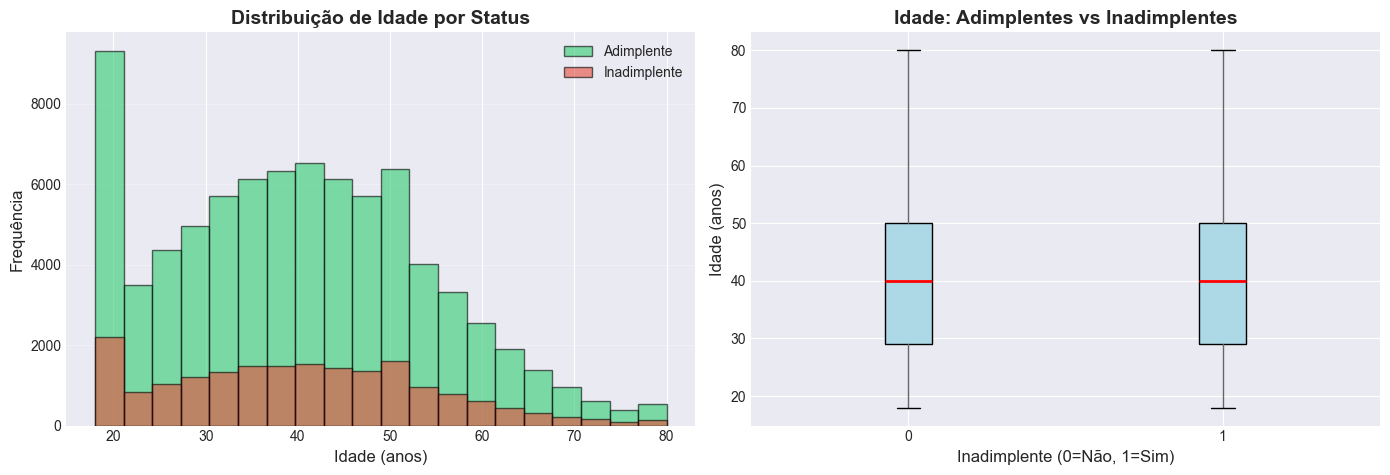

In [20]:
# Idade vs Inadimplência
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

# Histograma
df[df['inadimplente'] == 0]['idade'].hist(bins=20, alpha=0.6, label='Adimplente', 
                                            color='#2ecc71', ax=ax[0], edgecolor='black')
df[df['inadimplente'] == 1]['idade'].hist(bins=20, alpha=0.6, label='Inadimplente', 
                                            color='#e74c3c', ax=ax[0], edgecolor='black')
ax[0].set_title('Distribuição de Idade por Status', fontsize=14, fontweight='bold')
ax[0].set_xlabel('Idade (anos)', fontsize=12)
ax[0].set_ylabel('Frequência', fontsize=12)
ax[0].legend()
ax[0].grid(axis='y', alpha=0.3)

# Boxplot
df.boxplot(column='idade', by='inadimplente', ax=ax[1], patch_artist=True,
           boxprops=dict(facecolor='lightblue', color='black'),
           medianprops=dict(color='red', linewidth=2))
ax[1].set_title('Idade: Adimplentes vs Inadimplentes', fontsize=14, fontweight='bold')
ax[1].set_xlabel('Inadimplente (0=Não, 1=Sim)', fontsize=12)
ax[1].set_ylabel('Idade (anos)', fontsize=12)
plt.suptitle('')

plt.tight_layout()
plt.show()

### 💡 INSIGHT

**Idade NÃO é um fator decisivo:** ambos os grupos têm média de ~40 anos. A inadimplência está mais ligada a fatores financeiros do que demográficos.

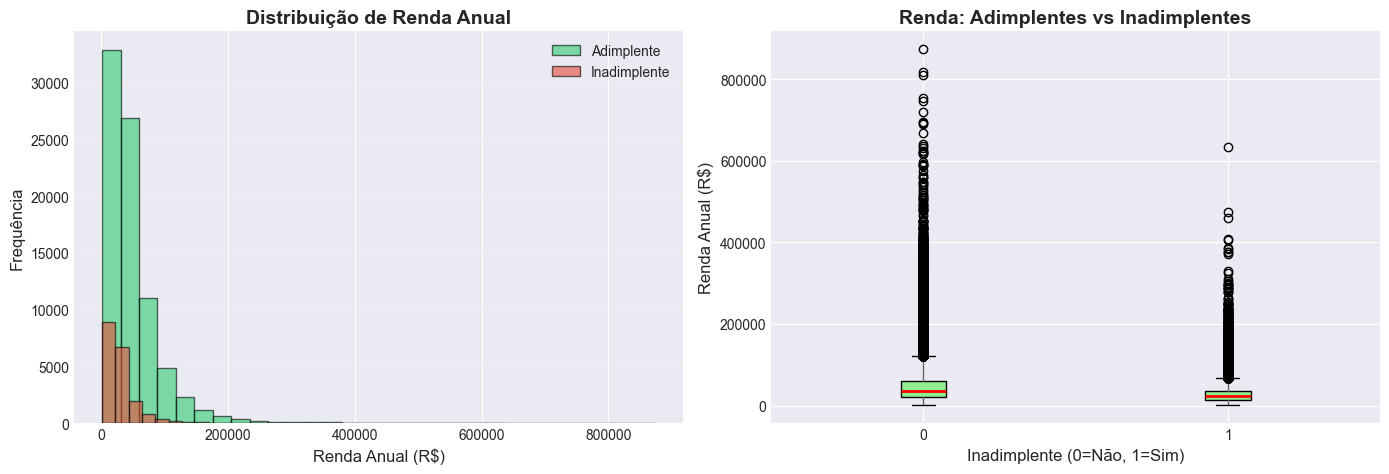

💰 Estatísticas de Renda por Status:
                count          mean           std      min        25%  \
inadimplente                                                            
0             80797.0  48548.923179  45138.610823  1116.79  20646.240   
1             19203.0  30989.843992  29749.100464   689.83  14789.235   

                   50%        75%        max  
inadimplente                                  
0             36032.90  60793.330  873983.11  
1             23007.77  35582.735  634858.84  


In [ ]:
# Renda Anual vs Inadimplência
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

# Histograma
df[df['inadimplente'] == 0]['renda_anual'].hist(bins=30, alpha=0.6, label='Adimplente', 
                                                  color='#2ecc71', ax=ax[0], edgecolor='black')
df[df['inadimplente'] == 1]['renda_anual'].hist(bins=30, alpha=0.6, label='Inadimplente', 
                                                  color='#e74c3c', ax=ax[0], edgecolor='black')
ax[0].set_title('Distribuição de Renda Anual', fontsize=14, fontweight='bold')
ax[0].set_xlabel('Renda Anual (R$)', fontsize=12)
ax[0].set_ylabel('Frequência', fontsize=12)
ax[0].legend()
ax[0].grid(axis='y', alpha=0.3)

# Boxplot
df.boxplot(column='renda_anual', by='inadimplente', ax=ax[1], patch_artist=True,
           boxprops=dict(facecolor='lightgreen', color='black'),
           medianprops=dict(color='red', linewidth=2))
ax[1].set_title('Renda: Adimplentes vs Inadimplentes', fontsize=14, fontweight='bold')
ax[1].set_xlabel('Inadimplente (0=Não, 1=Sim)', fontsize=12)
ax[1].set_ylabel('Renda Anual (R$)', fontsize=12)
plt.suptitle('')

plt.tight_layout()
plt.show()

### 💡 INSIGHT

**Diferença brutal na renda:** inadimplentes ganham **56.7% a menos** (R$ 31k vs R$ 48.5k). Renda baixa é um forte indicador de risco de crédito. Mediana de R$ 23k pode ser um threshold crítico.

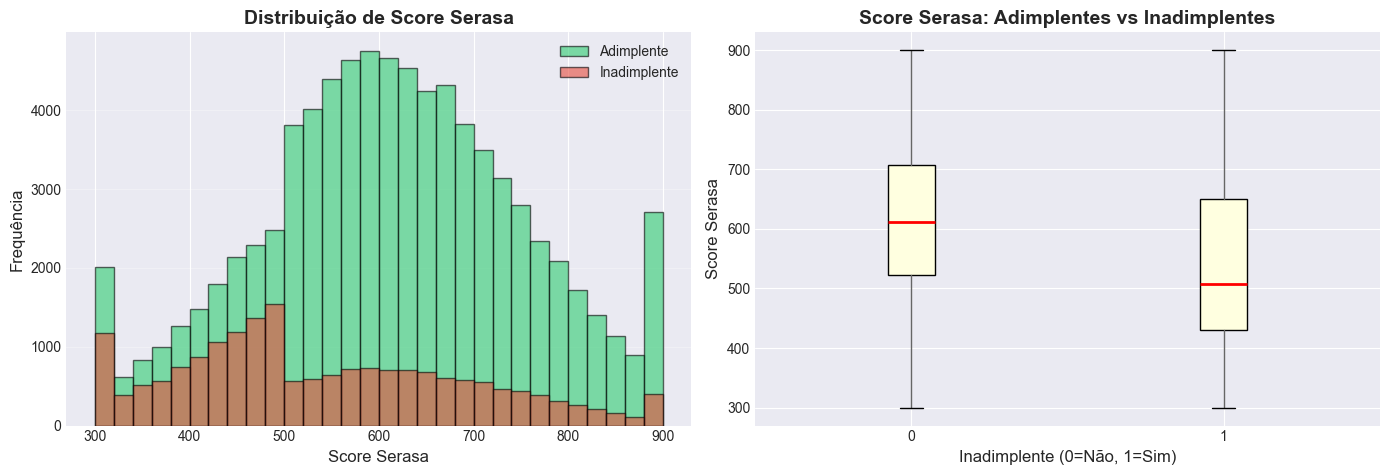

In [21]:
# Score Serasa vs Inadimplência
fix, ax = plt.subplots(1, 2, figsize=(14, 5))

# Histograma
df[df['inadimplente'] == 0]['score_serasa_externo'].hist(bins=30, alpha=0.6, label='Adimplente', 
                                                           color='#2ecc71', ax=ax[0], edgecolor='black')
df[df['inadimplente'] == 1]['score_serasa_externo'].hist(bins=30, alpha=0.6, label='Inadimplente', 
                                                           color='#e74c3c', ax=ax[0], edgecolor='black')
ax[0].set_title('Distribuição de Score Serasa', fontsize=14, fontweight='bold')
ax[0].set_xlabel('Score Serasa', fontsize=12)
ax[0].set_ylabel('Frequência', fontsize=12)
ax[0].legend()
ax[0].grid(axis='y', alpha=0.3)

# Boxplot
df.boxplot(column='score_serasa_externo', by='inadimplente', ax=ax[1], patch_artist=True,
           boxprops=dict(facecolor='lightyellow', color='black'),
           medianprops=dict(color='red', linewidth=2))
ax[1].set_title('Score Serasa: Adimplentes vs Inadimplentes', fontsize=14, fontweight='bold')
ax[1].set_xlabel('Inadimplente (0=Não, 1=Sim)', fontsize=12)
ax[1].set_ylabel('Score Serasa', fontsize=12)
plt.suptitle('')

plt.tight_layout()
plt.show()

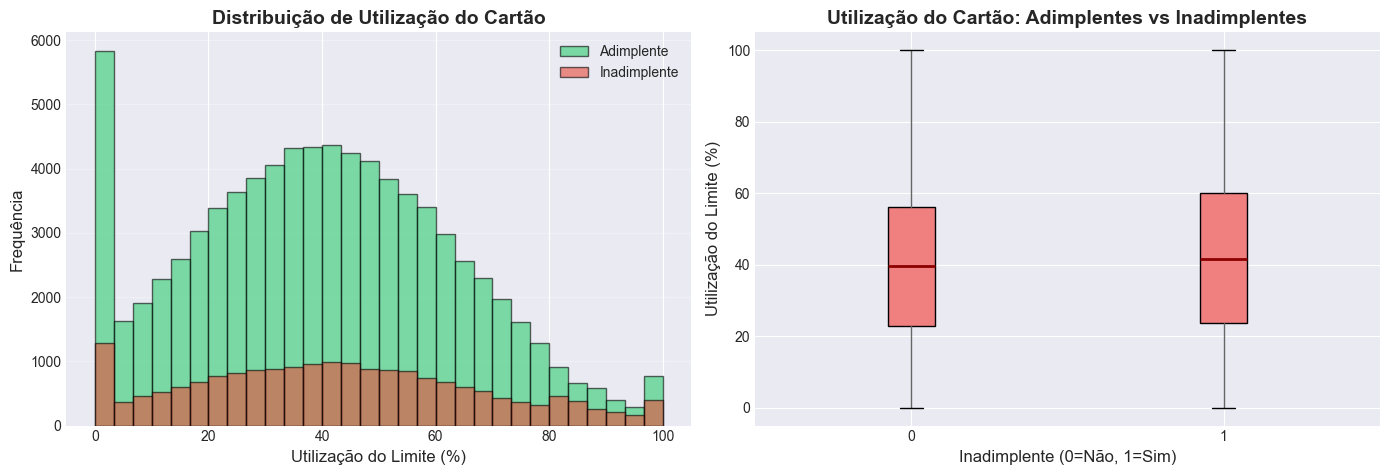

In [22]:
# Utilização de Cartão vs Inadimplência
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

# Histograma
df[df['inadimplente'] == 0]['utilizacao_limite_cartao'].hist(bins=30, alpha=0.6, label='Adimplente', 
                                                               color='#2ecc71', ax=ax[0], edgecolor='black')
df[df['inadimplente'] == 1]['utilizacao_limite_cartao'].hist(bins=30, alpha=0.6, label='Inadimplente', 
                                                               color='#e74c3c', ax=ax[0], edgecolor='black')
ax[0].set_title('Distribuição de Utilização do Cartão', fontsize=14, fontweight='bold')
ax[0].set_xlabel('Utilização do Limite (%)', fontsize=12)
ax[0].set_ylabel('Frequência', fontsize=12)
ax[0].legend()
ax[0].grid(axis='y', alpha=0.3)

# Boxplot
df.boxplot(column='utilizacao_limite_cartao', by='inadimplente', ax=ax[1], patch_artist=True,
           boxprops=dict(facecolor='lightcoral', color='black'),
           medianprops=dict(color='darkred', linewidth=2))
ax[1].set_title('Utilização do Cartão: Adimplentes vs Inadimplentes', fontsize=14, fontweight='bold')
ax[1].set_xlabel('Inadimplente (0=Não, 1=Sim)', fontsize=12)
ax[1].set_ylabel('Utilização do Limite (%)', fontsize=12)
plt.suptitle('')

plt.tight_layout()
plt.show()

---
# 4️⃣ VARIÁVEIS CATEGÓRICAS vs INADIMPLÊNCIA
---

🎓 ESCOLARIDADE vs INADIMPLÊNCIA

% de Inadimplentes por Escolaridade:
escolaridade
Fundamental      20.1
Médio            19.8
Superior         19.8
Pós-graduação    13.3
Name: 1, dtype: float64


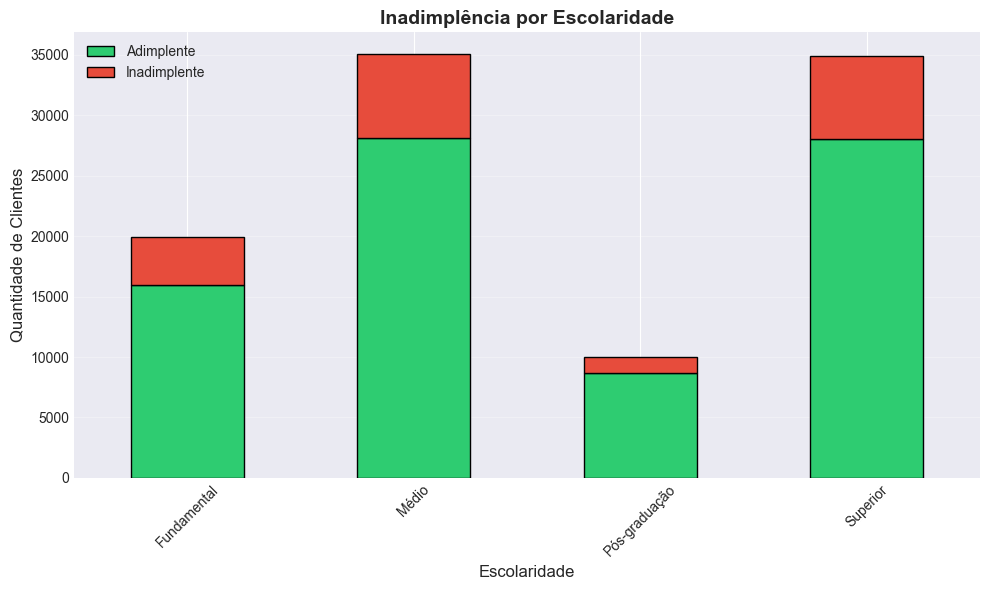

In [44]:
# Escolaridade vs Inadimplência
tabela = pd.crosstab(df['escolaridade'], df['inadimplente'], normalize='index') * 100

print("🎓 ESCOLARIDADE vs INADIMPLÊNCIA")
print("=" * 60)
print("\n% de Inadimplentes por Escolaridade:")
print(tabela[1].sort_values(ascending=False).round(1))

# Barras
tabela_count = pd.crosstab(df['escolaridade'], df['inadimplente'])
tabela_count.plot(kind='bar', stacked=True, figsize=(10, 6), 
                   color=['#2ecc71', '#e74c3c'], edgecolor='black')
plt.title('Inadimplência por Escolaridade', fontsize=14, fontweight='bold')
plt.xlabel('Escolaridade', fontsize=12)
plt.ylabel('Quantidade de Clientes', fontsize=12)
plt.legend(['Adimplente', 'Inadimplente'], loc='upper left')
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

💼 OCUPAÇÃO vs INADIMPLÊNCIA

% de Inadimplentes por Ocupação:
ocupacao
Desempregado    64.0
CLT             16.9
Autônomo        16.7
Empresário      16.6
Name: 1, dtype: float64


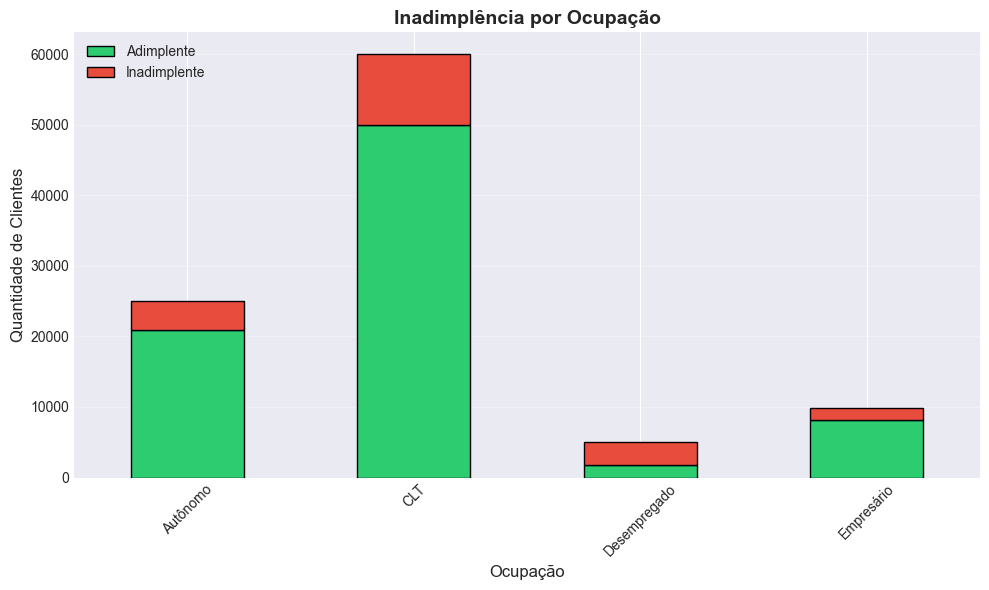

In [45]:
# Ocupação vs Inadimplência
tabela = pd.crosstab(df['ocupacao'], df['inadimplente'], normalize='index') * 100

print("💼 OCUPAÇÃO vs INADIMPLÊNCIA")
print("=" * 60)
print("\n% de Inadimplentes por Ocupação:")
print(tabela[1].sort_values(ascending=False).round(1))

# Barras
tabela_count = pd.crosstab(df['ocupacao'], df['inadimplente'])
tabela_count.plot(kind='bar', stacked=True, figsize=(10, 6), 
                   color=['#2ecc71', '#e74c3c'], edgecolor='black')
plt.title('Inadimplência por Ocupação', fontsize=14, fontweight='bold')
plt.xlabel('Ocupação', fontsize=12)
plt.ylabel('Quantidade de Clientes', fontsize=12)
plt.legend(['Adimplente', 'Inadimplente'], loc='upper left')
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

🎯 TOP 8 CORRELAÇÕES COM INADIMPLÊNCIA
 1. score_serasa_externo           ⬇️ NEGATIVA  | -0.197 🟢 FRACA
 2. historico_atraso_90_dias       ⬆️ POSITIVA  |  0.174 🟢 FRACA
 3. possui_imovel_proprio          ⬇️ NEGATIVA  | -0.164 🟢 FRACA
 4. renda_anual                    ⬇️ NEGATIVA  | -0.160 🟢 FRACA
 5. valor_patrimonio               ⬇️ NEGATIVA  | -0.125 🟢 FRACA
 6. tempo_emprego_atual            ⬇️ NEGATIVA  | -0.105 🟢 FRACA
 7. possui_carro                   ⬇️ NEGATIVA  | -0.070 🟢 FRACA
 8. utilizacao_limite_cartao       ⬆️ POSITIVA  |  0.047 🟢 FRACA


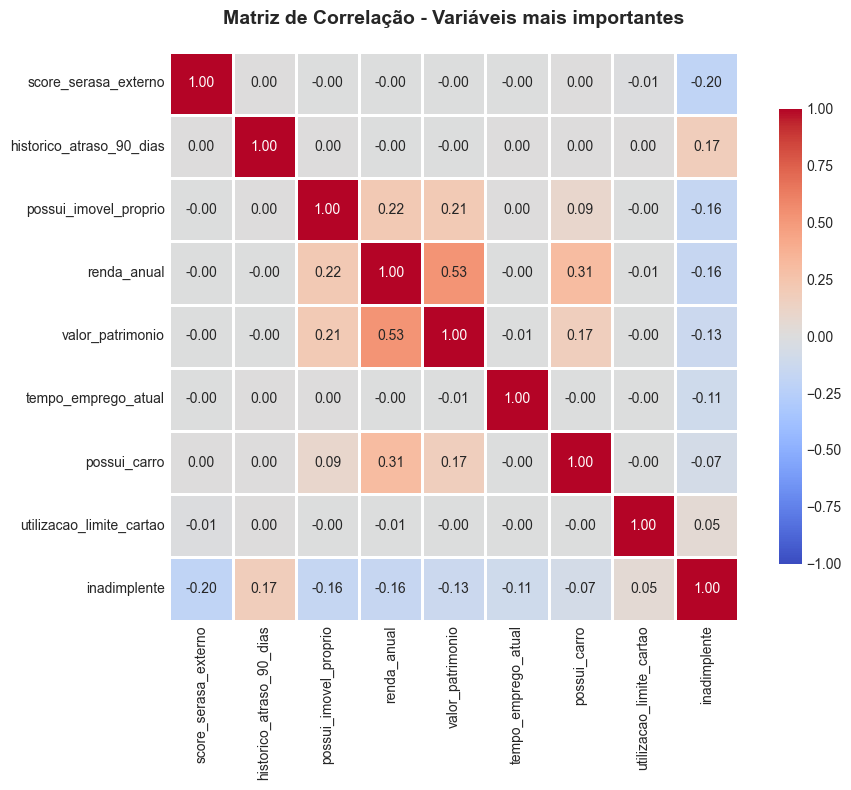

In [52]:
# Correlação com o Target
df_numeric = df.select_dtypes(include=[np.number])
correlacao = df_numeric.corr()

print("🎯 TOP 8 CORRELAÇÕES COM INADIMPLÊNCIA")
print("=" * 60)

corr_target = correlacao['inadimplente'].drop('inadimplente').abs().sort_values(ascending=False)

for i, (var, valor) in enumerate(corr_target.head(8).items(), 1):
    direcao = "⬆️ POSITIVA" if correlacao.loc[var, 'inadimplente'] > 0 else "⬇️ NEGATIVA"
    forca = "🔴 FORTE" if valor > 0.5 else "🟡 MODERADA" if valor > 0.3 else "🟢 FRACA"
    print(f"{i:2}. {var:<30} {direcao:12} | {correlacao.loc[var, 'inadimplente']:>6.3f} {forca}")

# Heatmap das variáveis mais importantes
top_vars = corr_target.head(8).index.tolist() + ['inadimplente']
corr_top = df_numeric[top_vars].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_top, annot=True, fmt='.2f', cmap='coolwarm', center=0, 
            square=True, linewidths=1, cbar_kws={"shrink": 0.8}, vmin=-1, vmax=1)
plt.title('Matriz de Correlação - Variáveis mais importantes', fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()